# Исследование данных сети фитнес-центров.

Краткое описание проекта: провести анализ данных и разработать рекомендации по повышению качества работы с клиентами, меры по снижению оттока.

Входные данные - данные, которые содержат информацию на месяц до оттока и факт оттока на определённый месяц.

Заказчик - сеть фитнес-центров.

Цель проекта - на основании анализа данных дать рекомендации бизнесу.

Описание данных:

Данные клиента за предыдущий до проверки факта оттока месяц: 
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента: 
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

План работы: 
1. Считать, вывести, изучить информацию.
2. Произвести предобработку данных, преобразовать при необходимости.
3. Исследовать категориальные и числовые данные.
4. Построить модели прогнозирования.
5. Произвести кластеризацию клиентов.
5. Сделать общий вывод по работе.

### Чтение, выведение информации о датафрейме.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:\\Users\\HP\\Desktop\\Yandex\\14_machine_learning\Project\\gym_churn.csv')

In [4]:
# выведем данные
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


Категориальные признаки представлены в виде чисел (0- нет, 1- есть; 1-мужчина, 0-женщина).

In [5]:
'Размер датасета:', df.shape

('Размер датасета:', (4000, 14))

В датасете 4000 наблюдений (строк), достаточно много, чтобы работать с моделями.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Заменим тип значений в столбцах Avg_additional_charges_total(без копеек), Month_to_end_contract (т.к.по данным целое кол-во месяцев) на int. Avg_class_frequency_total и Avg_class_frequency_current_month оставим как есть.

In [7]:
df = df.astype({'Avg_additional_charges_total':'int','Month_to_end_contract':'int'},errors='ignore')

### Исследовательский анализ данных (EDA)

####  Проверка отсутствующих значений (пропусков), изучение средних значений и стандартных отклонений.

In [8]:
# проверим отсутствующие значения
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [9]:
# проверим дубликаты по строкам
df.duplicated().sum()

0

In [10]:
# Посмотрим на числовое описание данных
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.438000,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.370579,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.000000,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.000000,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.000000,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.000000,12.000000,31.000000,6.023668,6.146783,1.000000


Анализ средних зачений (mean) и стандартного отклонения (std) признаков показывает большую разницу по столбцам Age, Avg_additional_charges_total. Это говорит о разбросе значений и, возможно, наличии выбросов. Возраст от 18 до 41 года, разброс большой, но аномальных значений и выбросов нет. Проверим Avg_additional_charges_total (доп. выручку).

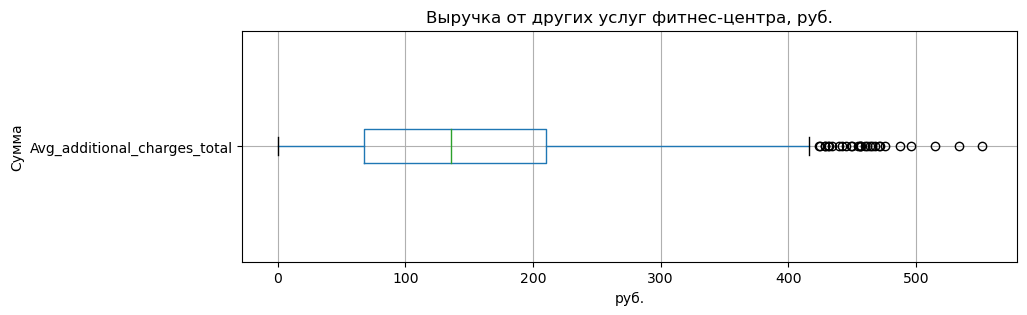

In [11]:
df.boxplot(column='Avg_additional_charges_total', figsize=(10,3), vert = False) # Построим диаграмму размаха
plt.title("Выручка от других услуг фитнес-центра, руб.")
plt.xlabel("руб.")
plt.ylabel("Сумма")
plt.show()


Значения около 500 и более руб. идентифицируются как выбросы, но это не аномалии, вполне реалистичные значения. Оставим.

In [12]:
# Посмотрим на соотношение групп оттока
'Соотношение групп оттока:',round(df['Churn'].value_counts()/len(df['Churn']),2)

('Соотношение групп оттока:',
 0    0.73
 1    0.27
 Name: Churn, dtype: float64)

Группа оттока составляет 27%.

#### Cредние значения признаков в двух группах (нет оттока/отток)

In [13]:
# Посмотрим на средние значения признаков в группах оттока
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,157.941817,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,114.572102,1.662582,0.990575,1.474995,1.044546


Наблюдаем существенную разницу средних значений в двух группах (не отток/отток) в столбцах Contract_period,Month_to_end_contract, Lifetime, Avg_additional_charges_total. Получается, что чем больше срок контракта, срок до окончания контракта, общее время пользования услугами,  тем больше доп. выручка от других услуг фитнес-центра. Это логично, первые три временнЫх показателя взаимосвязаны, выручка от доп. услуг больше в группе, где отсутствует отток.

#### Гистограммы и распределение признаков в двух группах (нет оттока/отток)

In [14]:
#Функция для распределениия категориальных переменных
def cat(data, col, title):
    df=data.groupby([col, 'Churn']).size().reset_index()
    df.columns = 'Признак', 'Отток', 'Кол-во'
    df['Признак'] = df['Признак'].replace({0:'Нет', 1:'Да'})
    df['Отток'] = df['Отток'].replace({0:'Не отток', 1:'Отток'})
    
    sns.set_style('dark')
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Признак", y="Кол-во", data=df, hue='Отток')
    plt.title('Распределение клиентов по признаку:' + title)
    plt.xlabel('Признак')
    plt.ylabel('Количество')
    # выбираем положение легенды и указываем размер шрифта
    plt.legend(loc='upper right', fontsize=10)
    plt.grid()
    plt.show();

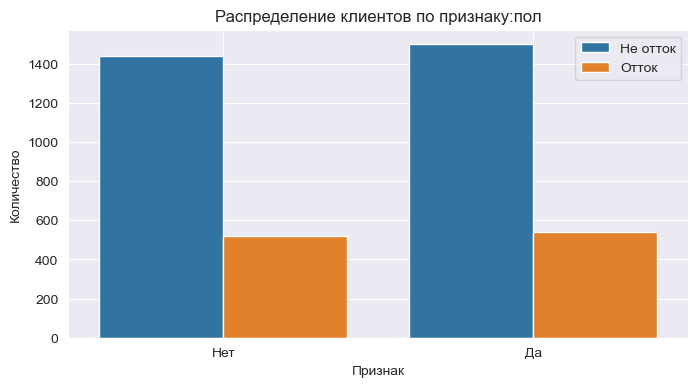

In [15]:
cat(df, df['gender'], 'пол')

Признак пола не влияет на отток. График показывает приблизительно одинаковые доли оттока среди клиентов обоих полов.

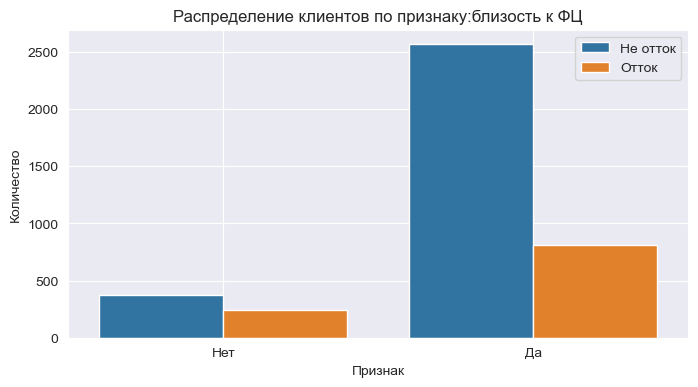

In [16]:
cat(df, df['Near_Location'], 'близость к ФЦ')

Если клиент живет/работает далеко от фитнес-центра, то доля оттока составляет приблизительно 0,4. Если клиент живет/работает рядом с фитнес-центром, то доля оттока составляет приблизительно 0,2. Предположительно удаленность влияет на отток.

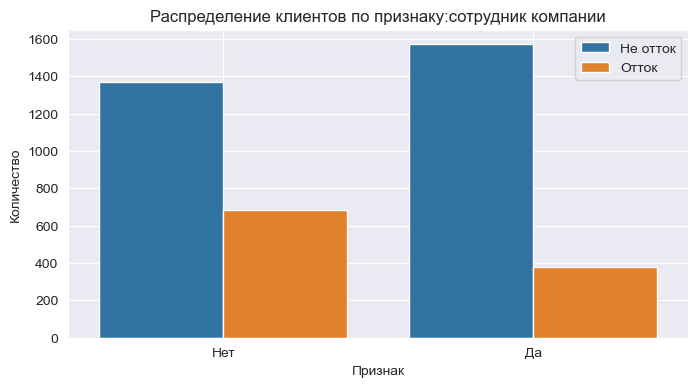

In [17]:
cat(df, df['Partner'],'сотрудник компании')

Доля оттока клиентов, которые являются сотрудниками компаний-партнеров и могут получать скидки на абонемент ниже, составляет 0,2. В то время как доля оттока клиентов, которые купили абонемент не через работодателя составляет 0,33.Предположительно, этот признак влияет на отток.

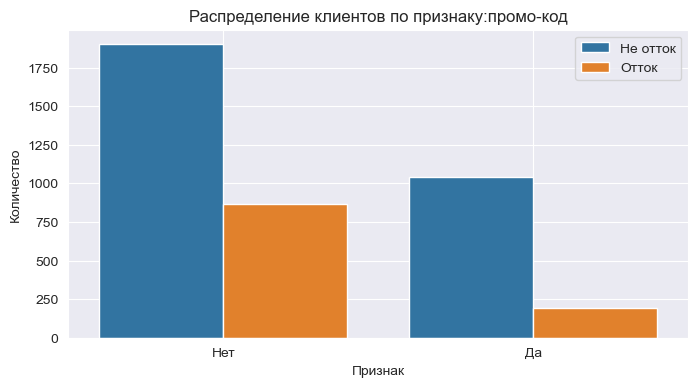

In [18]:
cat(df, df['Promo_friends'],'промо-код')

Доля оттока среди клиентов, которые воспользовались промо-кодом составляет 0,16, в то время как доля оттока среди клиентов, которые не воспользовались промо-кодом составляет 0,31. Признак влияет на отток.

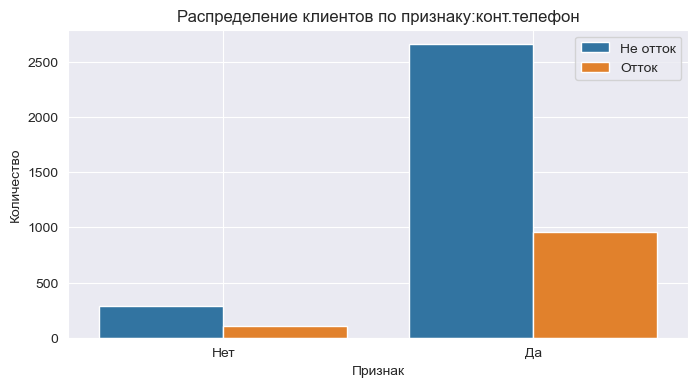

In [19]:
cat(df, df['Phone'],'конт.телефон')

График показывает, что в основном клиенты оставляют свой контактнный телефон. Данный признак не влияет на отток по житейскому опыту.

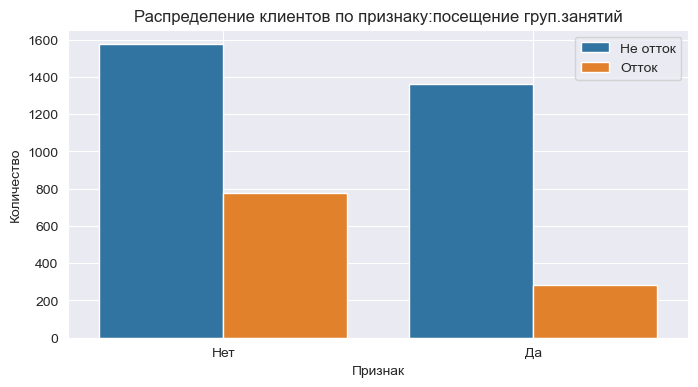

In [20]:
cat(df, df['Group_visits'],'посещение груп.занятий')

Клиенты, не посещающие групповые занятия имеют большую долю оттока. 

In [21]:
# сделаем срезы по группам оттока и построим гистограммы по признакам
df_сlient = df.query('Churn == 0') # группа клиентов
df_churn = df.query('Churn == 1')  # группа оттока

In [22]:
# напишем функцию для выведения гистограмм по числовым значениям по группам оттока
def num(data, datan, col, title):
    data[col].hist(bins=15, label = 'Клиент', alpha=0.6, figsize=(8, 6)) 
    datan[col].hist(bins=15, label = 'Отток')
    plt.legend()
    plt.title('Распределение клиентов по признаку:' + title)
    plt.xlabel(title)
    plt.ylabel("Частота встречаемости") 
    plt.show()

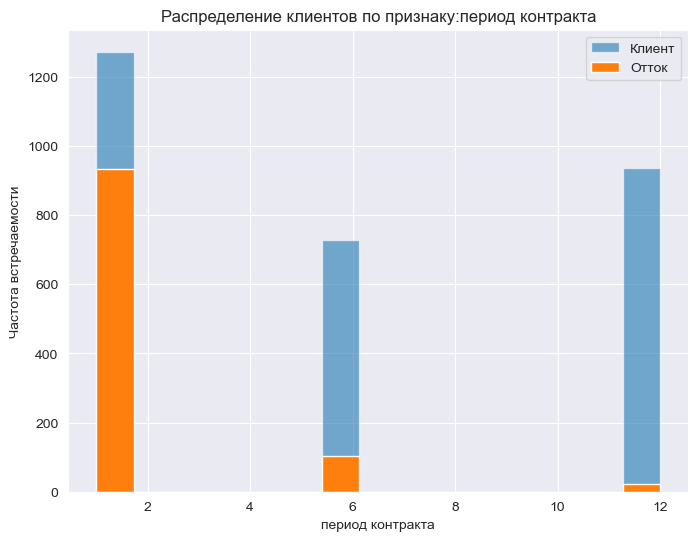

In [23]:
num(df_сlient, df_churn, 'Contract_period','период контракта')

Максимальная доля оттока у клиентов со сроком абонемента 1 месяц, минимальнвая - 12 месяцев.

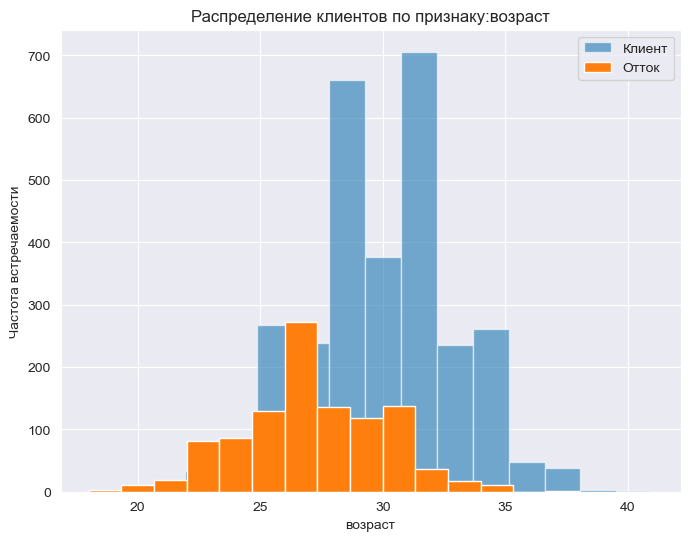

In [24]:
num(df_сlient, df_churn, 'Age','возраст')

В группе оттока клиенты до 35 лет, в группе клиентов - до 40 лет.
Пик значений в группе оттока - 26 лет, в группе клиентов - 29, 31 год.

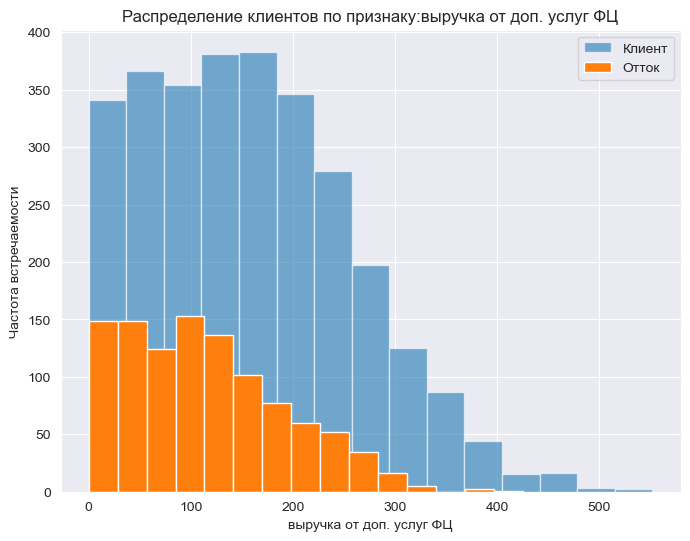

In [25]:
num(df_сlient, df_churn, 'Avg_additional_charges_total','выручка от доп. услуг ФЦ')

Клиенты тратят деньги на доп. услуги фитнес-центра больше и чаще.

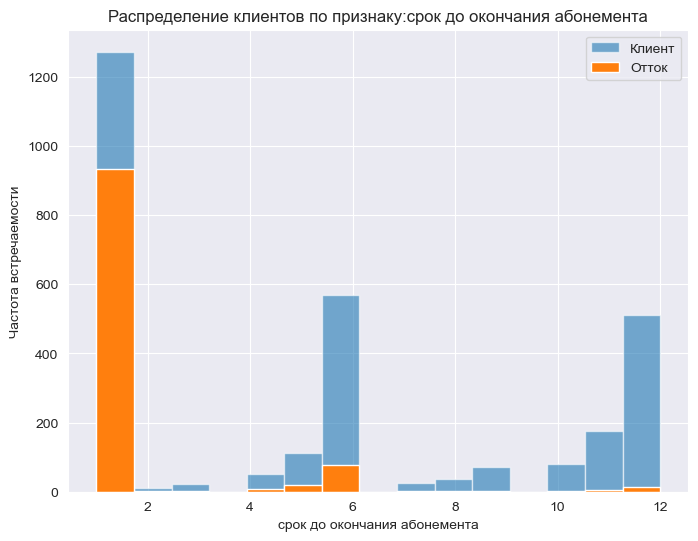

In [26]:
num(df_сlient, df_churn, 'Month_to_end_contract','срок до окончания абонемента')

Максимальную долю оттока клиентов видим за 1 месяц до окончания срока абонемента. Доля за 6 месяцев незначительная, за 12 месяцев - незначительная.

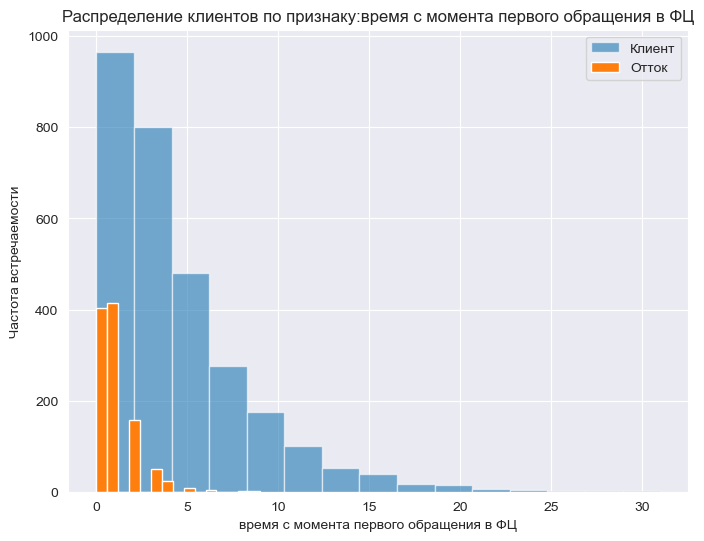

In [27]:
num(df_сlient, df_churn, 'Lifetime','время с момента первого обращения в ФЦ')

Пик значений Lifetime для клиентов приходится на 2 месяца и мксимальное значение - до 23 месяцев. В группе оттока пик значений приходится на 0,5 месяца и единичные значения после 5 месяцев.

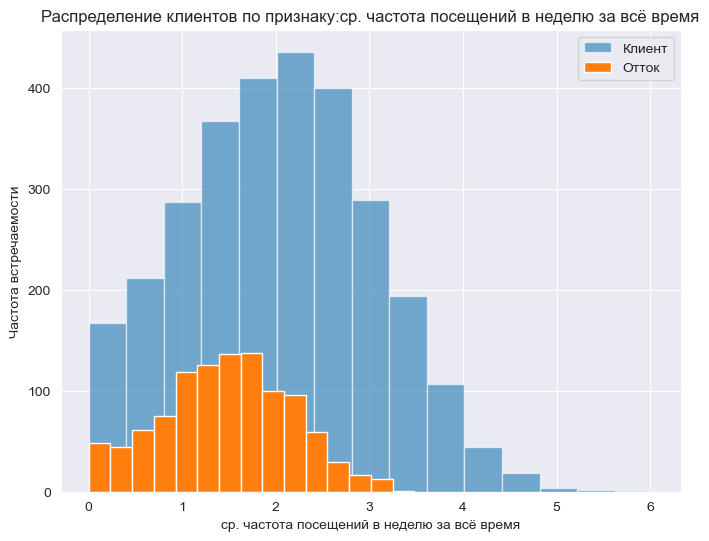

In [28]:
num(df_сlient, df_churn, 'Avg_class_frequency_total','ср. частота посещений в неделю за всё время')

Средняя частота посещений в неделю за всё время с начала действия абонемента в группе клиентов - 2,5 раза, единичные значения около 5 раз и более. Средняя частота посещений в неделю за всё время с начала действия абонемента в группе оттока - 1,5 раза, максимальные значения - около 3 раз в неделю.

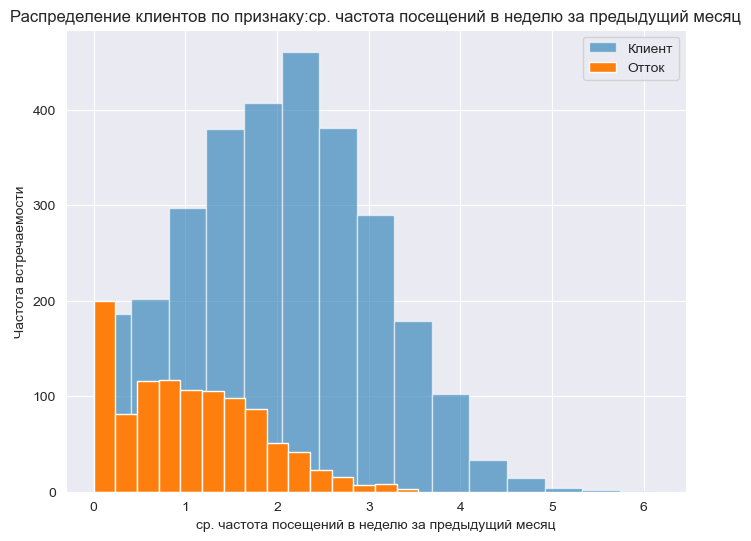

In [29]:
num(df_сlient, df_churn, 'Avg_class_frequency_current_month','ср. частота посещений в неделю за предыдущий месяц')

Средняя частота посещений в неделю за предыдущий месяц в группе клиентов - 2,5 раза, единичные значения около 5 раз и более. Средняя частота посещений в неделю за предыдущий месяц в группе оттока - 1 раз, единичные значения - около 3 раз в неделю.

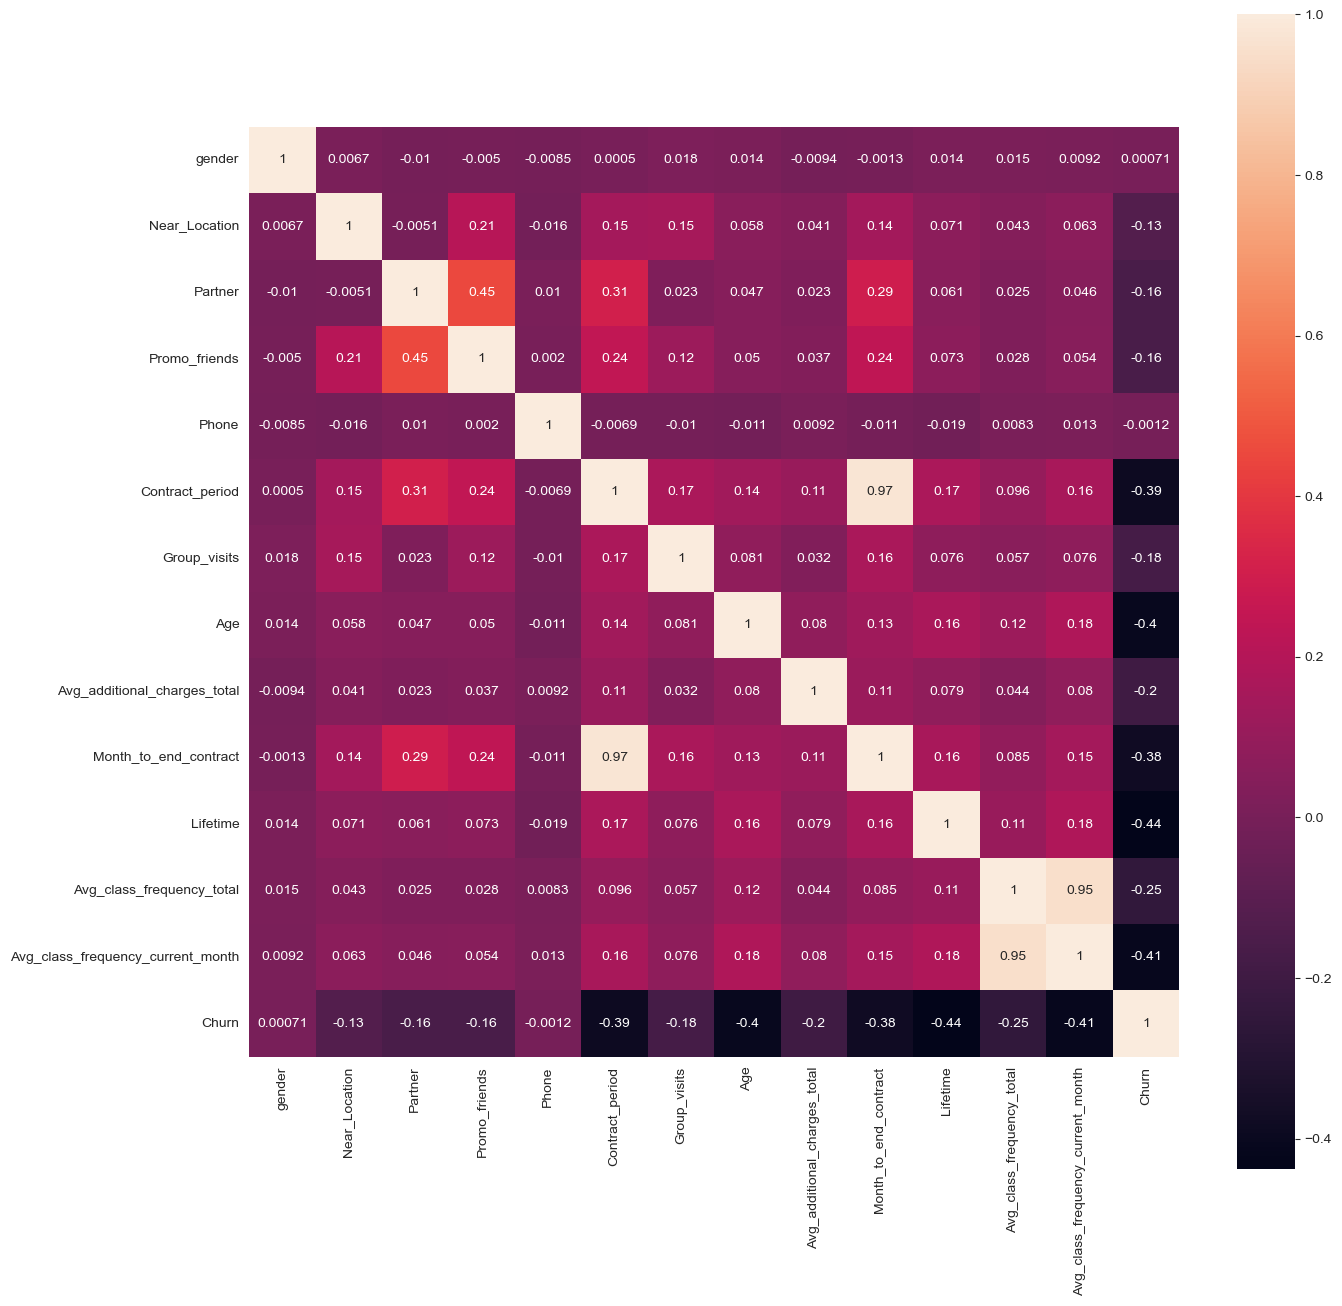

In [30]:
# Построим корреляционную матрицу признаков
corr_m = df.corr()

# Нарисуем heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True )
plt.show()


По матрице корреляции признаков видим высокую корреляцию между 'Contract_period' и 'Month_to_end_contract'. Также между 	'Avg_additional_charges_total' и 'Avg_class_frequency_current_month'. Эти признаки мультиколлинеарные. С оттоком у всех признаков корреляция отрицательная.

### Построение модели прогнозирования оттока клиентов

#### Разбивка данных на обучающую и валидационную выборку

In [31]:
# Разделим данные на признаки (матрица X) и целевую переменную- отток (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

In [32]:
# Разделим данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Обучение модели на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [33]:
# Обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [34]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [35]:
# Зададим модели
models = [LogisticRegression(random_state=0, solver='liblinear'), RandomForestClassifier(random_state=0)]

In [36]:
# Напишем функцию, которая принимает на вход модель и выводит метрики
def metrics(m, X_train, y_train, X_test, y_test, title):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print()

#### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение  моделей по метрикам. 

In [37]:
# Напишем цикл, который выводит метрики по списку моделей
for i in models:
     
    metrics(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
        title= i
)


LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.92
Precision: 0.85
Recall: 0.83

RandomForestClassifier(random_state=0)
Accuracy: 0.91
Precision: 0.84
Recall: 0.80



Значение всех трех метрик выше у модели логистической регрессии, чем у случайного леса. Аccuracy (доля верно угаданных ответов) выше на 0,01. Но поскольку соотношение групп оттока у нас не поровну, учитываем другие метрики. Также на 0,01 больше значение precision (доля прогнозов относительно целевого класса оттока "1"). Метрика Recall нацелена на минимизацию противоположных рисков — recall показывает, сколько реальных объектов "1" класса мы смогли обнаружить. Значение этой метрики выше у модели логистической регрессии на 0,03. В целом модель логистической регрессии зарекомендовала себя лучше на основании метрик.

### Кластеризация клиентов

#### Стандартизация данных

In [38]:
scaler = StandardScaler() # создаём объект класса scaler для стандартизации
X_sc = scaler.fit_transform(df.drop(columns = ['Churn'])) # обучаем объект класса scaler и преобразуем набор данных

#### Матрица расстояний и дендрограмма

In [39]:
linked = linkage(X_sc, method = 'ward') 

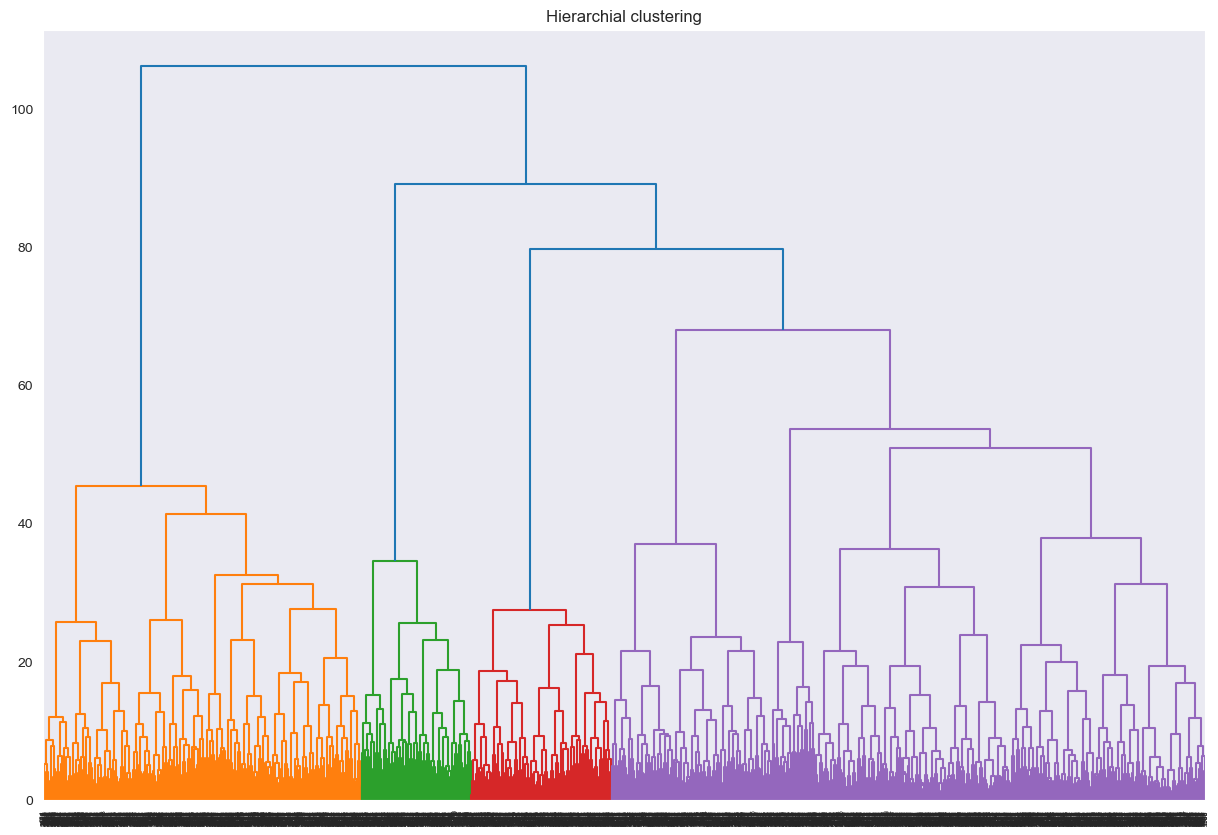

In [40]:
# Визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Судя по дендрограмме число кластеров можно принять за 5 (по количеству вертикальных линий, пересеченных воображаемой горизонтальной линией над кластерами). По разделению цветами кластеров 4.  Количество цветов тоже можно взять за число кластеров, но цвет характеризует "расстояние" между объектами. Примем за количество кластеров- 5.

#### Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов. 

In [41]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 

In [42]:
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

In [43]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

#### Cредние значения признаков для кластеров

In [44]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.265347,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.472727,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,134.942574,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.108558,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.147971,2.459427,4.898568,2.852002,2.850161,0.068019


Зафиксируем характерные признаки кластеров по средним значениям:
- Первый кластер (индекс 0) -  клиенты, которые являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки, покупают  абонементы на 12 месяцев , живут/работают поблизости с фитнес-центром. Они чаще посещают групповые занятия, чаще пользуются другими услугами фитнес-центра (кафе, спорттовары, косметический и массажный салон).
- Второй кластер (индекс 1) - клиенты с абонементом 6 месяцев, которые живут/работают рядом  с фитнес-центром. Приблизительно половина из них являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки.
- Третий кластер (индекс 2) - клиенты, которые живут/работают достаточно далеко. Приблизительно половина из них являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки, не пользуются промо-кодами. Покупают абонементы на 1-6 месяцев.
- Четвертый кластер (индекс 3) - клиенты, которые живут/работают рядом с с фитнес-центром, покупают абонементы на 1 месяц. (возможно пробные).
- Пятый кластер (индекс 4) - клиенты, которые живут/работают рядом с с фитнес-центром, покупают абонементы на 6 месяцев. Они чаще посещают групповые занятия, чаще пользуются другими услугами фитнес-центра (кафе, спорттовары, косметический и массажный салон).

#### Распределения признаков по кластерам

In [45]:
#Функция для распределениия категориальных переменных по кластерам
def cat_cl(data, col, title):
    df=data.groupby([col,'cluster_km']).size().reset_index()
    df.columns = 'Признак', 'Кластер', 'Кол-во'
    df['Признак'] = df['Признак'].replace({0:'Нет', 1:'Да'})
    
    sns.set_style('dark')
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Признак", y="Кол-во", data=df, hue='Кластер')
    plt.title('Распределение клиентов по признаку:' + title)
    plt.xlabel('Признак')
    plt.ylabel('Количество')
    # выбираем положение легенды и указываем размер шрифта
    plt.legend(loc='upper right', fontsize=10)
    plt.grid()
    plt.show();

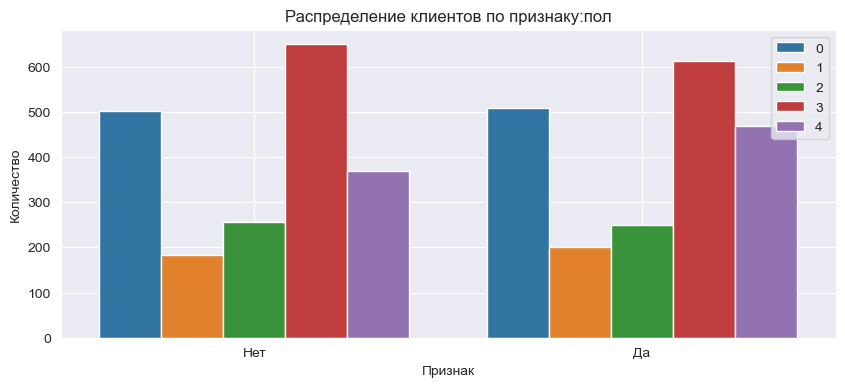

In [46]:
cat_cl(df, df['gender'], 'пол')

Во всех кластерах представлено примерно одинаковое количество клиентов обоего пола.

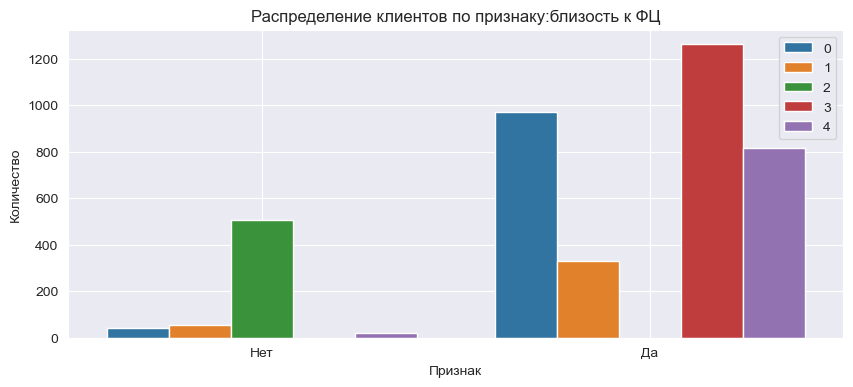

In [47]:
cat_cl(df, df['Near_Location'], 'близость к ФЦ')

В кластере с  индексом 2 находятся клиенты, которые живут/работают делеко от фитнес-центра. Большинство клиентов, которые живут/работают рядом с фитнес-центром находятся в кластерах 0,3,4.

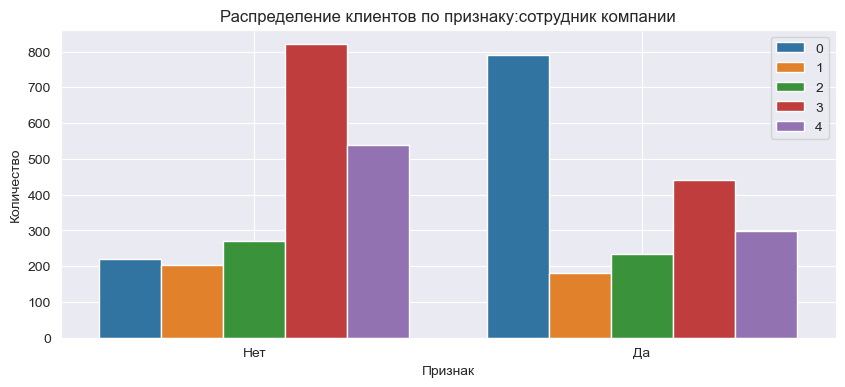

In [48]:
cat_cl(df, df['Partner'], 'сотрудник компании')

Клиенты, которые не являются сотрудниками компаний-партнеров в большинстве своем находятся в кластерах с индексами 3 и 4. Большинство клиентов, которые являются сотрудниками компаний-партнеров, находятся в кластере с индексом 0.

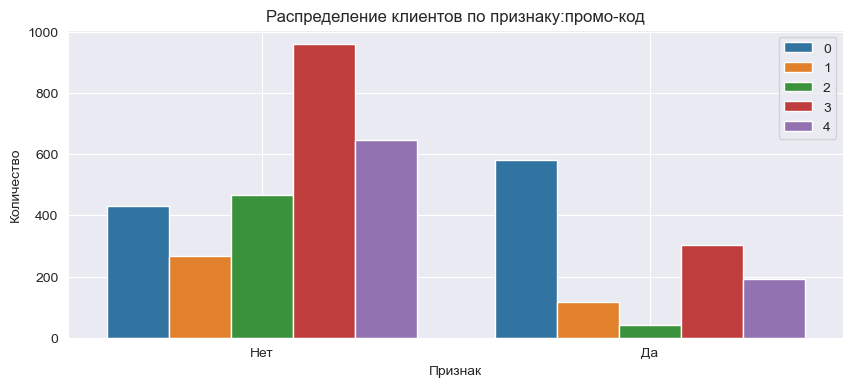

In [49]:
cat_cl(df, df['Promo_friends'], 'промо-код')

Максимальное значение по использованию промо-кодов в кластере с индексом 0. Максимальное значение по неиспользованию промо-кодов в кластере с индексом 3.

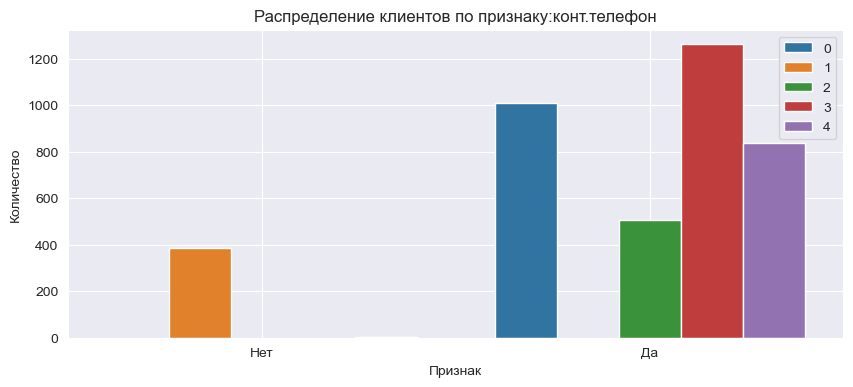

In [50]:
cat_cl(df, df['Phone'], 'конт.телефон')

Не указан контактный телефон только в кластере с индексом 1.

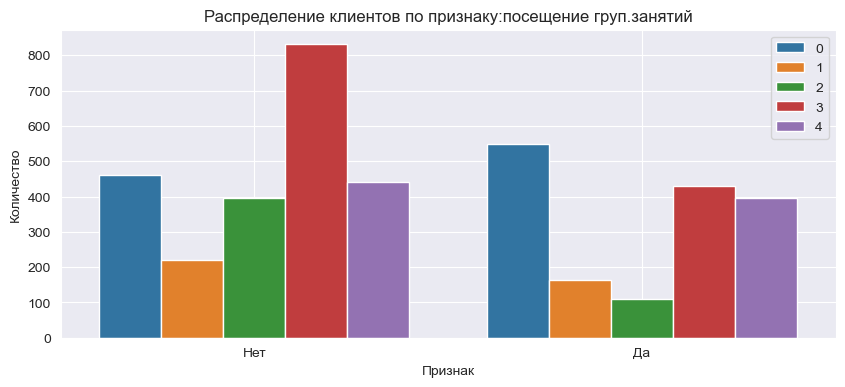

In [51]:
cat_cl(df, df['Group_visits'],'посещение груп.занятий')

Клиенты, у которых нет признака посещения групповых занятий есть во всех кластерах, максимум в кластере с индексом 3. Посещают групповые занятия, в основном клиенты, находящиеся в кластерах 0, 3, 4.

In [52]:
df.head(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14,5,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113,12,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129,1,2,1.859098,1.736502,0,3


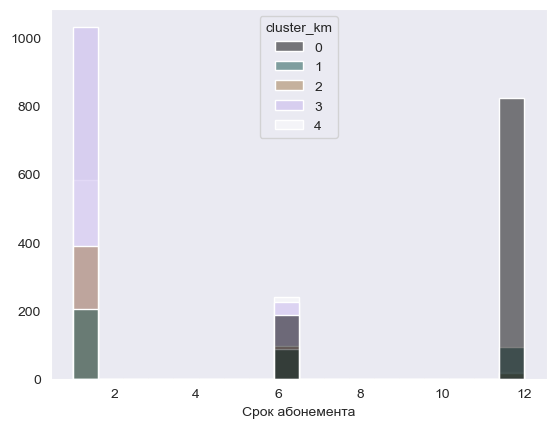

In [53]:
# Изучим распределение числовых признаков по категориям
sns.histplot(data=df, x='Contract_period', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Срок абонемента')
plt.show();

Абонементы на 1 мес. покупают в основном клиенты  кластера с индексом 3. Абонементы на 12 мес. покупают в основном клиенты  кластера с индексом 0. 

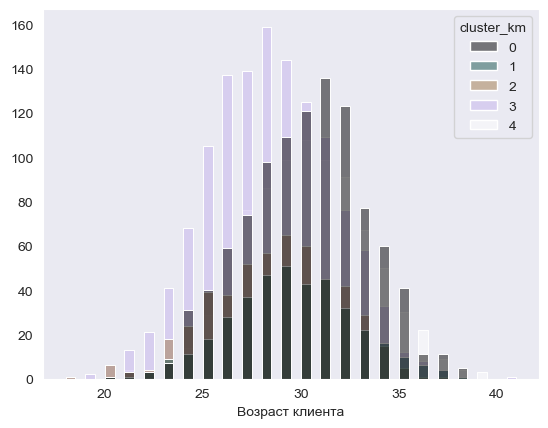

In [54]:
sns.histplot(data=df, x='Age', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Возраст клиента')
plt.show();

Интересно, что от 23 до 29 лет примерно половина клиентов каждого года рождения находится в кластере с индексом 3.

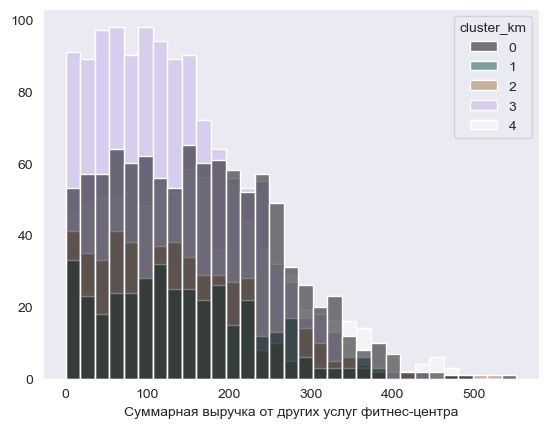

In [55]:
sns.histplot(data=df, x='Avg_additional_charges_total', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Суммарная выручка от других услуг фитнес-центра')
plt.show();

Основную доп.выручку до 250 руб. делают клиенты кластеров 0,1,2,3,4.

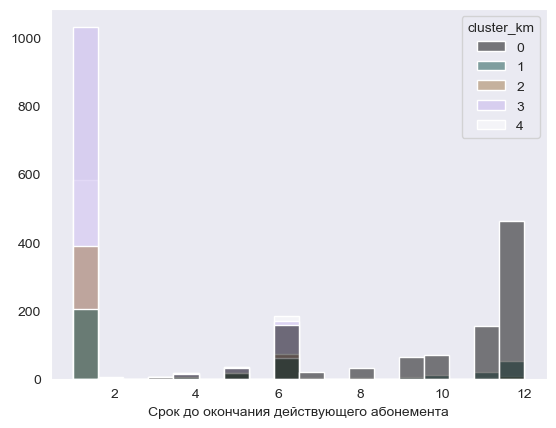

In [56]:
sns.histplot(data=df, x='Month_to_end_contract', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Срок до окончания действующего абонемента')
plt.show();

Срок до окончания действующего абонемента 1 мес. - большинство клиентов в кластере 3.  А 6 и 12 мес - в кластере 0.  

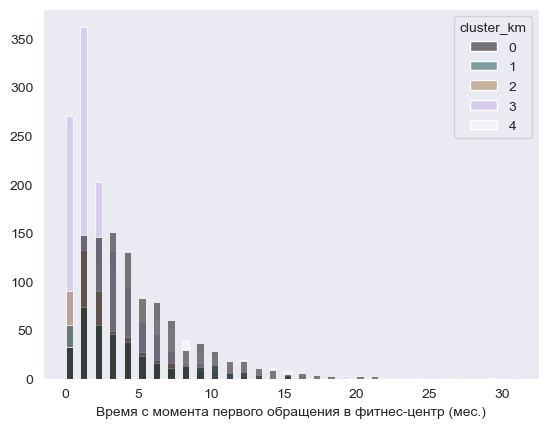

In [57]:
sns.histplot(data=df, x='Lifetime', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Время с момента первого обращения в фитнес-центр (мес.)')
plt.show();

До 30 месяцев доживают единицы.Представлены все кластеры.

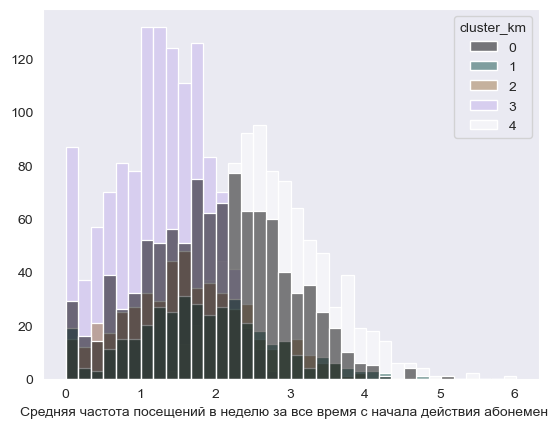

In [58]:
sns.histplot(data=df, x='Avg_class_frequency_total', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Средняя частота посещений в неделю за все время с начала действия абонемента')
plt.show();

Минимум посещений в неделю в целом у клиентов 3 кластера, максимум - у клиентов 4 кластера. 

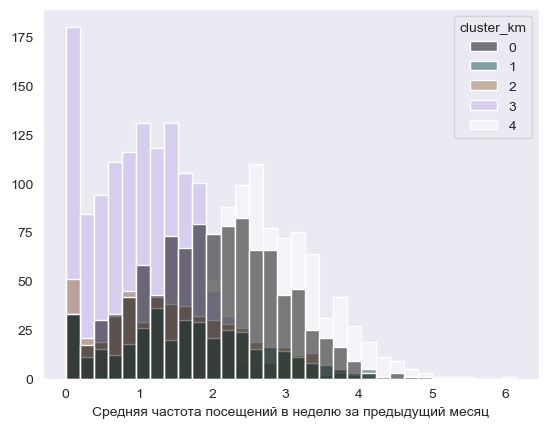

In [59]:
sns.histplot(data=df, x='Avg_class_frequency_current_month', hue='cluster_km', palette='cubehelix')
plt.ylabel('')
plt.xlabel('Средняя частота посещений в неделю за предыдущий месяц')
plt.show();

Те же данные по распределениям.

#### Доля оттока для каждого полученного кластера  

In [60]:
# Посмотрим на распределение внутри кластеров
df_cluster_churn = df.groupby('cluster_km')['Churn'].value_counts()
df_cluster_churn

cluster_km  Churn
0           0        982
            1         28
1           0        282
            1        103
2           0        281
            1        224
3           1        649
            0        613
4           0        781
            1         57
Name: Churn, dtype: int64

In [61]:
df_cluster = df.groupby(['cluster_km', 'Churn']).size().reset_index()
df_cluster.columns = 'Кластер', 'Отток', 'Кол-во'

In [62]:
df_cluster['Кол-во в кластере'] = df_cluster.groupby(['Кластер'])['Кол-во'].cumsum()
df_cluster['Отток'] = df_cluster['Отток'].replace({0:'Не отток', 1:'Отток'})
df_cluster

,Кластер,Отток,Кол-во,Кол-во в кластере
0,0,Не отток,982,982
1,0,Отток,28,1010
2,1,Не отток,282,282
3,1,Отток,103,385
4,2,Не отток,281,281
5,2,Отток,224,505
6,3,Не отток,613,613
7,3,Отток,649,1262
8,4,Не отток,781,781
9,4,Отток,57,838


In [63]:
df_cluster_churn = df_cluster.query('Отток == "Отток"')
df_cluster_churn['Доля оттока в кластере'] = round((df_cluster_churn['Кол-во']/\
                                                    df_cluster_churn['Кол-во в кластере']),2)
df_cluster_churn = df_cluster_churn.rename(columns={'Кол-во': 'Кол-во оттока'})
df_cluster_churn

,Кластер,Отток,Кол-во оттока,Кол-во в кластере,Доля оттока в кластере
1,0,Отток,28,1010,0.03
3,1,Отток,103,385,0.27
5,2,Отток,224,505,0.44
7,3,Отток,649,1262,0.51
9,4,Отток,57,838,0.07


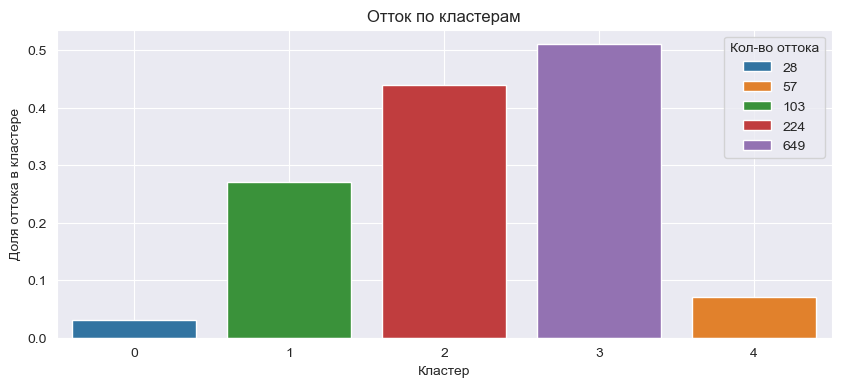

In [64]:
sns.set_style('dark')
plt.figure(figsize=(10, 4))
sns.barplot(x="Кластер", y="Доля оттока в кластере", data=df_cluster_churn, hue='Кол-во оттока', dodge=False, )
plt.title('Отток по кластерам')
plt.xlabel('Кластер')
plt.grid()
plt.show();

График показывает, что максимальное количество в третьем кластере. В нем же максимальное количество оттока.

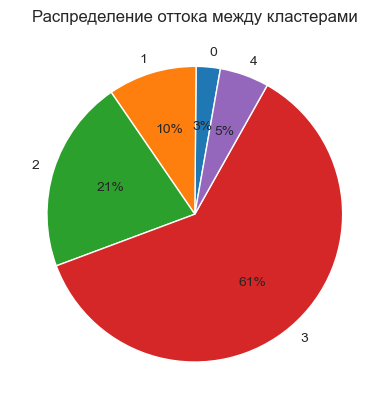

In [65]:
vals = df_cluster_churn['Кол-во оттока']
labels = df_cluster_churn['Кластер']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels,  startangle=80, autopct='%1.0f%%')
ax.set_title("Распределение оттока между кластерами")                                             
plt.show()

По оттоку лидируют 3 и 2 кластеры. График долей оттока показывает, что в третьем кластере доля оттока составляет 61%, во втром - 21%. 

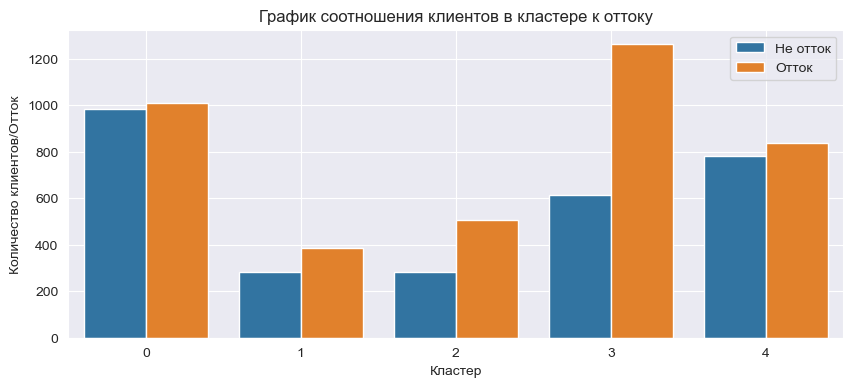

In [66]:
sns.set_style('dark')
plt.figure(figsize=(10, 4))
sns.barplot(x='Кластер', y='Кол-во в кластере', data=df_cluster, hue='Отток')
plt.title('График соотношения клиентов в кластере к оттоку')
plt.xlabel('Кластер')
plt.ylabel('Количество клиентов/Отток')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

График показывает соотношение групп отток/не отток по каждому кластеру. Максимальное количество оттока в 3 кластере (клиенты живут и работают далеко от фитнес-центра, покупают абонементы на 1-6 месяцев).

### Выводы и  базовые рекомендации по работе с клиентами

Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания. 
Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.


Анализ признаков показывает, что на отток влияют показатели:
    
- проживание или работа в районе, где находится фитнес-центр;
- сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент;
- использование промо-кода от знакомого при оплате первого абонемента

На отток не влияют признаки пола и возраста.

Характерные признаки клиента, попадающего в отток:
- покупает абонемент чаще всего на 1 мес.;
- самостоятельно покупает абонемент, не пользуется промо-кодами, скидками работодателя;
- меньше тратит денег на доп. услуги фитнес-центра;
- меньшее количество посещений фитнес-центра, в том числе групповых программ;
- меньше общий срок с момента первого посещения.

Мы разделили клиентов на кластеры:

- Кластер 0 - клиенты, которые являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки, покупают абонементы на 12 месяцев , живут/работают поблизости с фитнес-центром. Они чаще посещают групповые занятия, чаще пользуются другими услугами фитнес-центра (кафе, спорттовары, косметический и массажный салон);

- Кластер 1 - клиенты с абонементом 6 месяцев, которые живут/работают рядом с фитнес-центром. Приблизительно половина из них являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки;
 
- Кластер 2 - клиенты, которые живут/работают достаточно далеко. Приблизительно половина из них являются сотрудниками компаний-партнеров, получают за абонемент корпоративные скидки, не пользуются промо-кодами. Покупают абонементы на 1-6 месяцев;

- Кластер 3 - клиенты, которые живут/работают рядом с с фитнес-центром, покупают абонементы на 1 месяц. (возможно пробные);

- Кластер 4 - клиенты, которые живут/работают рядом с с фитнес-центром, покупают абонементы на 6 месяцев. Они чаще посещают групповые занятия, чаще пользуются другими услугами фитнес-центра (кафе, спорттовары, косметический и массажный салон).

Анализ показателей в разрезе кластеров подтверждает разбивку на кластеры.  

Максимальная доля оттока в кластере 3, минимальная - в кластере 0.

Рекомендации: 
- В кластере 0 у нас клиенты, которые покупают годовые абонементы со скидками от компаний-работодателей, пользуются промо-кодами, активно посещают клуб, приносят доп. доход от других услуг фитнес- центра. Нужно продолжать работу с компаниями-партнерами, возможно, расширить их список, продумать варианты спец. предложений для компаний-партнеров.
- В кластере 3 клиенты, которые покупают абонементы на месяц. Как вариант, с такими клиентами можно связываться перед окончанием срока абонемента, получать обратную связь, предлагать купить абонемент на срок 6/12 месяцев, предлагать скидку за покупку, например.
- В кластера 2  клиенты, которые живут и работают далеко от фитнес-центра. Для таких клиентов можно разработать абонемент выходного дня/семейный, чтобы приезжали семьей на день.